In [1]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import pandas as pd
import os

In [2]:
# Load CSV file with image labels
data_path = "C:\\Users\\USER\\Documents\\4-2  Thesis\\Dataset\\train_validate_set.csv"
image_dir = "C:\\Users\\USER\\Documents\\4-2  Thesis\\train_validation(1)"

In [3]:
# Load and preprocess the dataset
data = pd.read_csv(data_path)
data['file_path'] = data['image_id'].apply(lambda x: os.path.join(image_dir, x+".jpg"))
data['label'] = data['label'].astype(str)

In [4]:
# Parameters
img_height, img_width = 299, 299  # Image dimensions for Xception
batch_size = 32
epochs = 50

In [5]:
# Prepare Image Data Generator
data_gen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2
)

In [6]:
train_gen = data_gen.flow_from_dataframe(
    dataframe=data,
    directory=image_dir,
    x_col='file_path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = data_gen.flow_from_dataframe(
    dataframe=data,
    directory=image_dir,
    x_col='file_path',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 6523 validated image filenames belonging to 4 classes.
Found 1630 validated image filenames belonging to 4 classes.


In [7]:
# Load Xception model with pretrained weights and exclude top layer
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [8]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(4, activation='softmax')(x)  # Adjust output layer for 4 classes

model = Model(inputs=base_model.input, outputs=out)

In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [10]:
# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    steps_per_epoch=train_gen.samples // batch_size,
    validation_steps=val_gen.samples // batch_size,
    # callbacks=callbacks
)

Epoch 1/50
203/203 [==============================] - 28s 109ms/step - loss: 0.7294 - accuracy: 0.7412 - val_loss: 0.6265 - val_accuracy: 0.7563
Epoch 2/50
203/203 [==============================] - 20s 96ms/step - loss: 0.6042 - accuracy: 0.7717 - val_loss: 0.5738 - val_accuracy: 0.7744
Epoch 3/50
203/203 [==============================] - 18s 88ms/step - loss: 0.5595 - accuracy: 0.7868 - val_loss: 0.5513 - val_accuracy: 0.7744
Epoch 4/50
203/203 [==============================] - 18s 88ms/step - loss: 0.5359 - accuracy: 0.7911 - val_loss: 0.5389 - val_accuracy: 0.7831
Epoch 5/50
203/203 [==============================] - 18s 88ms/step - loss: 0.5070 - accuracy: 0.8042 - val_loss: 0.5292 - val_accuracy: 0.7850
Epoch 6/50
203/203 [==============================] - 18s 88ms/step - loss: 0.4892 - accuracy: 0.8133 - val_loss: 0.5189 - val_accuracy: 0.7919
Epoch 7/50
203/203 [==============================] - 18s 89ms/step - loss: 0.4735 - accuracy: 0.8225 - val_loss: 0.5090 - val_accuracy

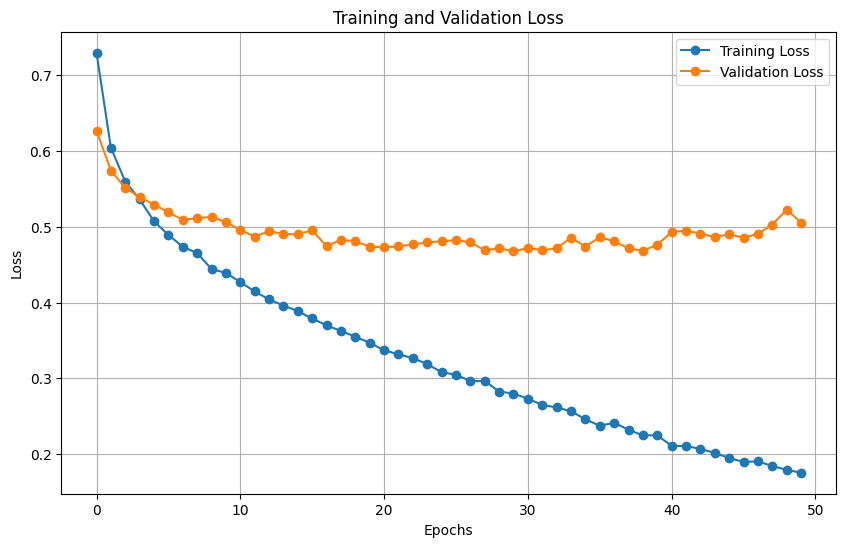

In [11]:
import matplotlib.pyplot as plt

# Plot training and validation loss
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

plot_loss(history)

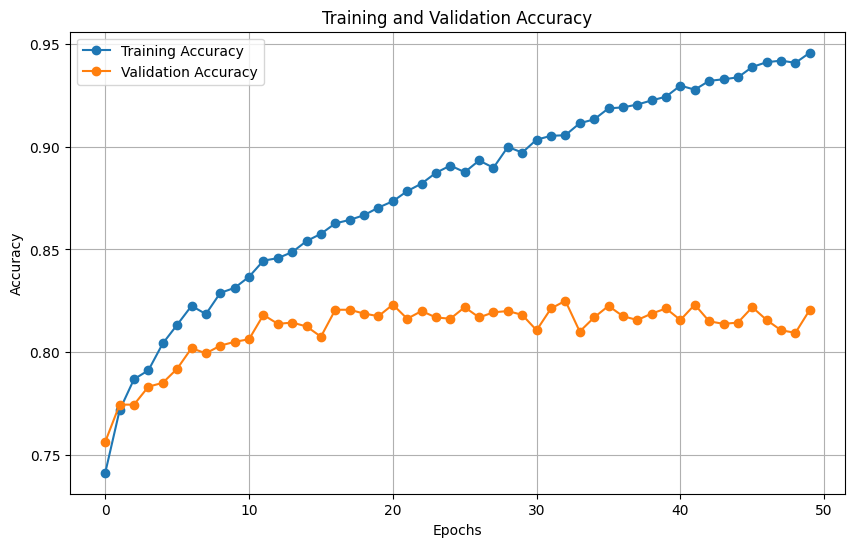

In [14]:
# Plot training and validation accuracy
import matplotlib.pyplot as plt
def plot_accuracy(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

plot_accuracy(history)

In [12]:
model.save("XceptionGPU.h5")

In [13]:
# Evaluate the model
eval_result = model.evaluate(val_gen)
print(f"Validation Loss: {eval_result[0]}, Validation Accuracy: {eval_result[1]}")

51/51 [==============================] - 3s 61ms/step - loss: 0.4812 - accuracy: 0.8172
Validation Loss: 0.48119720816612244, Validation Accuracy: 0.8171778917312622
